In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from decimal import *
import MySQLdb
import pandas.io.sql as psql
from MySQLdb.converters import conversions
from MySQLdb.constants import FIELD_TYPE
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
import keys

conversions[FIELD_TYPE.DECIMAL] = float
conversions[FIELD_TYPE.NEWDECIMAL] = float

conn = MySQLdb.connect(user=keys.SQL_user, host="localhost", db=keys.SQL_db, 
                       passwd=keys.SQL_password, charset='utf8',unix_socket="/tmp/mysql.sock")

Populating the interactive namespace from numpy and matplotlib


In [3]:
conn = MySQLdb.connect(user=keys.SQL_user, host="localhost", db=keys.SQL_db, passwd=keys.SQL_password, 
                       charset='utf8',unix_socket="/tmp/mysql.sock")

+-----------------------+

| Tables_in_illseeitall |

+-----------------------+

| attractions           |

| clusters              |

| clustersobjects       |

| commutetime           |

| hotels                |

+-----------------------+

## Read user input

In [4]:
user_input=['Los Angeles','3','150',[u'amusement', u'beach', u'business', u'casino', u'cityscape', u'golf', u'historic', u'marine', u'medical', u'monument', u'museums', u'park',u'school',u'shopping',u'sign',u'skiing',u'stadium',u'theater',u'winery']] 
#[u'amusement', u'beach', u'business', u'casino', u'cityscape', u'golf', u'historic', u'marine', u'medical', u'monument', u'museums', u'park',u'school',u'shopping',u'sign',u'skiing',u'stadium',u'theater',u'winery']

## Query all hotels with Sum[Commute/num_objects, relevant clusters]

In [5]:
cur = conn.cursor()
sql='DROP TEMPORARY TABLE IF EXISTS temp_table;'
cur.execute(sql)
sql='CREATE TEMPORARY TABLE temp_table'+\
    ' SELECT SUM(commutetime.CommuteTime/(%s)) AS TimeOverWeight, commutetime.EANHotelID FROM clustersobjects'%('+'.join(user_input[3]))+\
    ' INNER JOIN clusters ON clustersobjects.ClusterNum=clusters.ClusterNum'+\
    ' INNER JOIN commutetime ON commutetime.ClusterNum=clusters.ClusterNum'+\
    ' WHERE clusters.City="%s" GROUP BY commutetime.EANHotelID ORDER BY TimeOverWeight;'%(user_input[0])
cur.execute(sql)
sql='SELECT hotels.EANHotelID,hotels.Name,hotels.LowRate,hotels.Latitude,hotels.Longitude,'+\
    ' hotels.StarRating,temp_table.TimeOverWeight'+\
    ' FROM hotels INNER JOIN temp_table ON temp_table.EANHotelID=hotels.EANHotelID'+\
    ' WHERE hotels.StarRating>=%s AND hotels.LowRate<=%s;'%(user_input[1],user_input[2])
hotels=DataFrame(psql.read_sql(sql, conn))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: Warning: Unknown table 'illseeitall.temp_table'
  app.launch_new_instance()


In [6]:
hotels

,EANHotelID,Name,LowRate,Latitude,Longitude,StarRating,TimeOverWeight
0,105687,Sheraton Gateway Hotel Los Angeles Airport,139.0000,33.94556,-118.39019,3.5,142568.535104
1,109621,La Quinta Inn & Suites LAX,128.9900,33.94547,-118.37192,3.0,152026.884463
2,117242,Hollywood Hotel-The Hotel of Hollywood,109.0000,34.09278,-118.29171,3.0,89201.923993
3,138136,Courtyard by Marriott LAX,149.0000,33.94561,-118.39319,3.0,141905.750305
4,308868,JJ Grand Hotel - Wilshire,125.0000,34.06272,-118.30409,3.0,90464.561355
5,416625,Garden Suite Hotel,118.0000,34.06044,-118.30908,3.0,89939.436661
6,455313,Downtown LA Extended Stay,113.1467,34.06215,-118.24659,3.5,89842.741911
7,489884,West Hollywood Vintage Vacation Apt.,0.0000,34.07733,-118.36053,3.5,110384.823413


## Query all attractions in relevant clusters

In [11]:
sql='DROP TEMPORARY TABLE IF EXISTS temp_table;'
cur.execute(sql)
sql='CREATE TEMPORARY TABLE temp_table'+\
    ' SELECT %s AS Weight, clustersobjects.ClusterNum FROM clustersobjects'%('+'.join(user_input[3]))+\
    ' INNER JOIN clusters ON clustersobjects.ClusterNum=clusters.ClusterNum'+\
    ' WHERE clusters.City="%s"'%(user_input[0])
cur.execute(sql)
sql='SELECT RegionName,Latitude,Longitude,SubClassification,attractions.ClusterNum '+\
    ' FROM attractions INNER JOIN temp_table ON temp_table.ClusterNum=attractions.ClusterNum'+\
    ' WHERE temp_table.Weight>0 AND SubClassification IN ("%s");'%('","'.join(user_input[3]))

attractions=DataFrame(psql.read_sql(sql, conn))

In [12]:
sql='SHOW COLUMNS IN clustersobjects'
list(DataFrame(psql.read_sql(sql, conn)).Field[:-1])
typetocolor={u'amusement':'Crimson',
 u'beach':'Gold',
 u'business':'LightSkyBlue',
 u'casino':'OliveDrab',
 u'cityscape':'LightSlateGray',
 u'golf':'LawnGreen',
 u'historic':'FireBrick',
 u'marine':'MediumAquaMarine',
 u'medical':'MintCream',
 u'monument':'Navy',
 u'museums':'Purple',
 u'park':'Green',
 u'school':'DarkSlateGray',
 u'shopping':'Fuchsia',
 u'sign':'LightBlue',
 u'skiing':'Snow',
 u'stadium':'Yellow',
 u'theater':'Salmon',
 u'winery':'IndianRed'}

In [13]:
sql=' SELECT %s AS Weight, clusters.ClusterNum FROM clustersobjects'%('+'.join(user_input[3]))+\
    ' INNER JOIN clusters ON clustersobjects.ClusterNum=clusters.ClusterNum'+\
    ' WHERE clusters.City="%s" AND %s>0;'%(user_input[0],('+'.join(user_input[3])))
clusters=DataFrame(psql.read_sql(sql, conn))
biggest_cluster=clusters.ClusterNum[clusters.Weight==max(clusters.Weight)]

In [18]:
sql=' SELECT EANHotelID,CommuteTime FROM commutetime WHERE City="%s" AND ClusterNum=%i'%(user_input[0],int(biggest_cluster))
commute = DataFrame(psql.read_sql(sql, conn))

In [19]:
cur = conn.cursor()
sql='DROP TEMPORARY TABLE IF EXISTS temp_table;'
cur.execute(sql)
sql='CREATE TEMPORARY TABLE temp_table'+\
    ' SELECT SUM(commutetime.CommuteTime/(%s)) AS TimeOverWeight, commutetime.EANHotelID FROM clustersobjects'%('+'.join(user_input[3]))+\
    ' INNER JOIN clusters ON clustersobjects.ClusterNum=clusters.ClusterNum'+\
    ' INNER JOIN commutetime ON commutetime.ClusterNum=clusters.ClusterNum'+\
    ' WHERE clusters.City="%s" GROUP BY commutetime.EANHotelID ORDER BY TimeOverWeight;'%(user_input[0])
cur.execute(sql)
sql='SELECT hotels.EANHotelID,hotels.Name,hotels.LowRate,hotels.Latitude,hotels.Longitude,'+\
    ' hotels.StarRating,temp_table.TimeOverWeight'+\
    ' FROM hotels INNER JOIN temp_table ON temp_table.EANHotelID=hotels.EANHotelID;'
hotels=DataFrame(psql.read_sql(sql, conn))

In [20]:
df=hotels.merge(commute,on='EANHotelID')

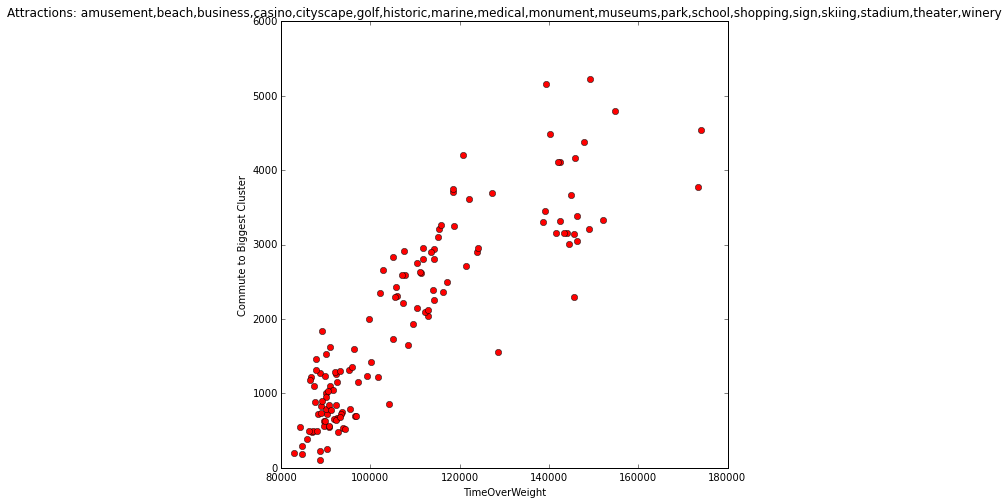

In [21]:
plt.figure(figsize=(8, 8))
plt.title('Attractions: '+','.join(user_input[3]))
plt.xlabel('TimeOverWeight')
plt.ylabel('Commute to Biggest Cluster')
plt.plot(df.TimeOverWeight,df.CommuteTime, 'ro')
savefig('%s_%s.png'%(user_input[0],'+'.join(user_input[3])))

# Data Vis Section

In [22]:
from __future__ import print_function
from bokeh.browserlib import view
from bokeh.document import Document
from bokeh.embed import file_html, components
from bokeh.models.glyphs import Circle
from bokeh.models import (
    GMapPlot, Range1d, ColumnDataSource,
    PanTool, WheelZoomTool, BoxSelectTool,
    BoxSelectionOverlay, GMapOptions, HoverTool,
    TapTool, OpenURL)
from bokeh.resources import INLINE

In [23]:
x_range = Range1d()
y_range = Range1d()

lat=list(attractions.Latitude)
lon=list(attractions.Longitude)

lath=list(hotels.Latitude)
lonh=list(hotels.Longitude)

# JSON style string taken from: https://snazzymaps.com/style/1/pale-dawn
map_options = GMapOptions(lat=mean(lat), lng=mean(lon), map_type="roadmap", zoom=12, styles="""
[{"featureType":"administrative","elementType":"all","stylers":[{"visibility":"on"},{"lightness":33}]},{"featureType":"landscape","elementType":"all","stylers":[{"color":"#f2e5d4"}]},{"featureType":"poi.park","elementType":"geometry","stylers":[{"color":"#c5dac6"}]},{"featureType":"poi.park","elementType":"labels","stylers":[{"visibility":"on"},{"lightness":20}]},{"featureType":"road","elementType":"all","stylers":[{"lightness":20}]},{"featureType":"road.highway","elementType":"geometry","stylers":[{"color":"#c5c6c6"}]},{"featureType":"road.arterial","elementType":"geometry","stylers":[{"color":"#e4d7c6"}]},{"featureType":"road.local","elementType":"geometry","stylers":[{"color":"#fbfaf7"}]},{"featureType":"water","elementType":"all","stylers":[{"visibility":"on"},{"color":"#acbcc9"}]}]
""")

plot = GMapPlot(
    x_range=x_range, y_range=y_range,
    map_options=map_options,
    title="San Francisco"
)
lat=list(attractions.Latitude)
lon=list(attractions.Longitude)
cluster_nn=list(attractions.ClusterNum)
#num_objects=[3,5,1]
#fill=['red', 'blue', 'orange']
#colors = [
#    "#%02x%02x%02x" % (np.floor(50+25*r), np.floor(20+50*g), 200) for r,g in zip(cluster_nn,cluster_nn)
#]
fill=[typetocolor[x] for x in attractions.SubClassification]
here=list(attractions.RegionName)

source = ColumnDataSource(
    data=dict(
        lat=lat,
        lon=lon,
        fill=fill,
        here=here
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size=15, fill_color="fill", line_color="black")
plot.add_glyph(source, circle)

here=list(hotels.Name)
size=map(int,list(max(hotels.TimeOverWeight)/hotels.TimeOverWeight*3))
source = ColumnDataSource(
    data=dict(
        lat=lath,
        lon=lonh,
        here=here,
        size=size
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size="size", fill_color="White", line_color="blue")
plot.add_glyph(source,circle)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()
hover = HoverTool(
        tooltips=[
            ("here", "@here"),
        ]
    )
url = "http://www.google.com"
tap = TapTool(plot=plot, callback=OpenURL(url=url))

plot.add_tools(pan, wheel_zoom, box_select,hover)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)
plot.tools.extend([tap])

doc = Document()
doc.add(plot)

if __name__ == "__main__":
    filename = "maps.html"
    with open(filename, "w") as f:
        f.write(file_html(doc, INLINE, "SF"))
    print("Wrote %s" % filename)
    view(filename)

Wrote maps.html


In [516]:
hotels.sort('TimeOverWeight')[0:3]

,EANHotelID,Name,LowRate,Latitude,Longitude,StarRating,TimeOverWeight
1,129842,The Andrews Hotel,142.4959,37.78785,-122.41226,3.0,417.459821
2,210688,Club Quarters in San Francisco,119.6008,37.79497,-122.40081,4.0,566.769345
0,107230,Holiday Inn Civic Center San Francisco,149.0000,37.77814,-122.41392,3.5,602.125000


In [454]:
script, div = components(plot)

In [455]:
from datetime import date
from random import randint

from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.io import output_file, show, vform

output_file("data_table.html")

data = dict(
        name=list(hotels.Name),
        rate=list(hotels.LowRate),
        commute=list(hotels.TimeOverWeight/max(hotels.TimeOverWeight)),
    )
source = ColumnDataSource(data)

columns = [
        TableColumn(field="name", title="Hotel"),
        TableColumn(field="rate", title="Rate"),
        TableColumn(field="commute", title="commute"),
    ]
data_table = DataTable(source=source, columns=columns, width=400, height=280)

script_t, div_t = components(vform(data_table))

In [456]:
import wikipedia
results = wikipedia.geosearch(latitude=37.826747, longitude=-122.421357, title='Alcatraz Island', results=10, radius=100)
page = wikipedia.page(results)

In [457]:
page.url
page.images[0]

u'https://upload.wikimedia.org/wikipedia/en/8/88/San_Francisco-Alcatraz-Utility_House-Power_Plant_Chimney-1930.jpg'

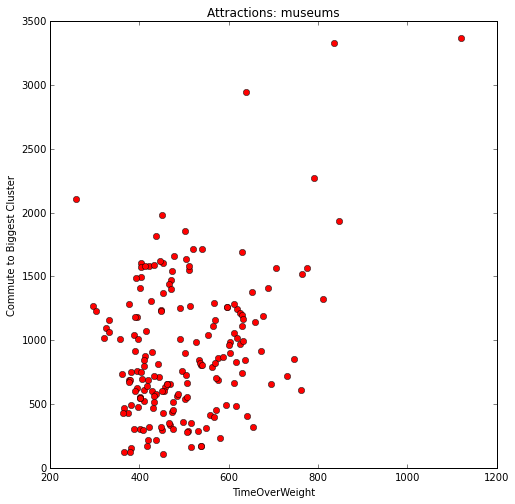

In [460]:
plt.figure(figsize=(8, 8))
plt.title('Attractions: '+','.join(user_input[3]))
plt.xlabel('TimeOverWeight')
plt.ylabel('Commute to Biggest Cluster')
plt.plot(df.TimeOverWeight,df.CommuteTime, 'ro')


In [380]:
import scraperwiki
import json
import datetime

def GetRecentCrimeParsed(lon,lat,radius):
  "imports recent crimes from the specified location"
  url = "http://api.spotcrime.com/crimes.json?lat="+str(lat)+"&lon="+str(lon)+"&radius="+str(radius)+"&callback=jQuery21307489185181912035_1442769040228&key=spotcrime-private-api-key&_=1442769040230"
  s = scraperwiki.scrape(url)
  parsed_json = json.loads(s.partition('(')[-1].rpartition(')')[0])
  return parsed_json

def GetRecentCrimeString(lon,lat,radius):
  "imports recent crimes from the specified location"
  url = "http://api.spotcrime.com/crimes.json?lat="+str(lat)+"&lon="+str(lon)+"&radius="+str(radius)+"&callback=jQuery21307489185181912035_1442769040228&key=spotcrime-private-api-key&_=1442769040230"
  s = scraperwiki.scrape(url)
  return (s.partition('(')[-1].rpartition(')')[0])

def WriteRecentCrimes(start,step):
    filename="recent_crimes_json_"+str(start)+"_"+str(start+step)+".txt"
    with open(filename,"a") as myfile:
        myfile.write("[")
        myfile.write('{"eanid":'+str(df.ix[start].EANHotelID)+","+
            GetRecentCrimeString(df.ix[start].Longitude,df.ix[start].Latitude,radius)[1:]+'\n')
        for index, row in df[1:].iterrows():
            myfile.write(',{"eanid":'+str(row.EANHotelID)+","+
                         GetRecentCrimeString(row.Longitude,row.Latitude,radius)[1:]+'\n')
        myfile.write("]")
    return filename

def ViolentCrimeCount(lon,lat,radius):
  crime_json=GetRecentCrimeParsed(lon=lon,lat=lat,radius=radius)
  crime_list=[]
  for crime in crime_json['crimes']:
      crime_dict={'Date': 'no date','Assault': 0, 'Burglary': 0, 'Other': 0, 'Theft': 0, 'Vandalism': 0,
                  'Arrest': 0, 'Arson': 0, 'Robbery': 0, 'Shooting':0}
      crime_dict[crime['type']] = crime_dict.get(crime['type'], 0) + 1
      crime_dict['Date'] = datetime.datetime.strptime((crime['date'])[0:8], "%m/%d/%y").date()
      crime_list.append(crime_dict)
  testdf=DataFrame(crime_list)
  testdf=testdf.groupby(by=testdf.Date).sum()
  violent_list=['Arrest','Arson','Assault','Shooting','Robbery','Vandalism']
  count=0
  for crime in violent_list:
    count += testdf[crime].sum()
  return count

def ViolentCrimeCountLastDays(lon,lat,radius,days):
  crime_json=GetRecentCrimeParsed(lon=lon,lat=lat,radius=radius)
  crime_list=[]
  for crime in crime_json['crimes']:
      crime_dict={'Date': 'no date','Assault': 0, 'Burglary': 0, 'Other': 0, 'Theft': 0, 'Vandalism': 0,
                  'Arrest': 0, 'Arson': 0, 'Robbery': 0, 'Shooting':0}
      crime_dict[crime['type']] = crime_dict.get(crime['type'], 0) + 1
      crime_dict['Date'] = datetime.datetime.strptime((crime['date'])[0:8], "%m/%d/%y").date()
      crime_list.append(crime_dict)
  testdf=DataFrame(crime_list)
  testdf=testdf.groupby(by=testdf.Date).sum()
  testdf=testdf[testdf.Date]
  violent_list=['Arrest','Arson','Assault','Shooting','Robbery','Vandalism']
  count=0
  for crime in violent_list:
    count += testdf[crime].sum()
  return count

In [388]:
  days=2
  crime_json=GetRecentCrimeParsed(lon=-122.40822,lat=37.78773,radius=0.1)
  crime_list=[]
  for crime in crime_json['crimes']:
      crime_dict={'Date': 'no date','Assault': 0, 'Burglary': 0, 'Other': 0, 'Theft': 0, 'Vandalism': 0,
                  'Arrest': 0, 'Arson': 0, 'Robbery': 0, 'Shooting':0}
      crime_dict[crime['type']] = crime_dict.get(crime['type'], 0) + 1
      crime_dict['Date'] = datetime.datetime.strptime((crime['date'])[0:8], "%m/%d/%y").date()
      crime_list.append(crime_dict)
  testdf=DataFrame(crime_list)
  testdf=testdf.groupby(by=testdf.Date).sum()
  violent_list=['Arrest','Arson','Assault','Shooting','Robbery','Vandalism']
  testdf

,Arrest,Arson,Assault,Burglary,Other,Robbery,Shooting,Theft,Vandalism
Date,,,,,,,,,
2015-09-29,4,0,0,3,19,3,2,16,3


In [389]:
hotels
ViolentCrimeCountLastDays(lon=-122.40822,lat=37.78773,radius=0.1,days=2)

12

In [397]:
hotels['Crime']=hotels.apply(lambda row: ViolentCrimeCount(lon=row.Longitude,
                                                               lat=row.Latitude,
                                                               radius=0.5), axis=1)

In [399]:
max(hotels.Crime)

3

In [403]:
attractions
print

<function print>

In [436]:
import wikipedia

def GetWikiUrl(lat,lon,title):
    results = wikipedia.geosearch(latitude=lat, longitude=lon, 
                                    title=title,results=10, radius=100)
    if len(results)>0:
        try:
            return wikipedia.page(results).url
        except:
            return ''
    else:
        return ''

attractions['Wiki']=attractions.apply(lambda row: GetWikiUrl(lon=row.Longitude,
                                                               lat=row.Latitude,
                                                               title=row.RegionName), axis=1)

In [433]:
import wikipedia
results = wikipedia.geosearch(latitude=37.826747, longitude=-122.421357,title='Alcatraz Island', radius=100)

In [434]:
wikipedia.page(results).url

u'https://en.wikipedia.org/wiki/Alcatraz_Island'

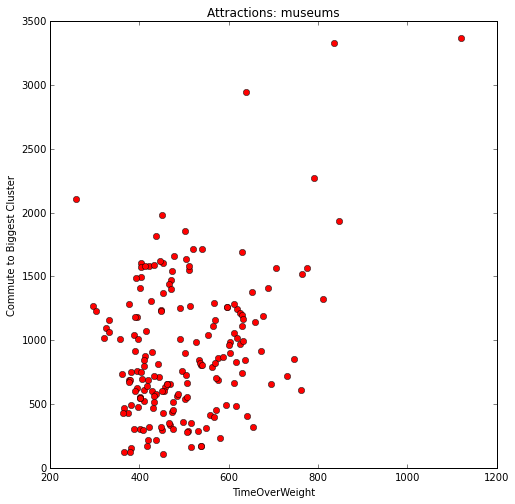

In [557]:
plt.figure(figsize=(8, 8))
plt.title('Attractions: '+','.join(user_input[3]))
plt.xlabel('TimeOverWeight')
plt.ylabel('Commute to Biggest Cluster')
plt.plot(df.TimeOverWeight,df.CommuteTime, 'ro')
savefig('%s_%s.png'%(user_input[0],'+'.join(user_input[3])))

In [1]:
import wikipedia
results = wikipedia.geosearch(latitude=37.826747, longitude=-122.421357,title='Alcatraz Island', radius=100)

In [25]:
sql = "Select * from attractions;"
attractions=DataFrame(psql.read_sql(sql, conn))

In [26]:
attractions

,RegionID,RegionName,RegionNameLong,Latitude,Longitude,SubClassification,TimeStamp,ClusterNum,City,Wiki,Crime
0,6239232,20 Mule Team Museum,"20 Mule Team Museum, Boron, California, United...",34.999574,-117.650608,museums,2015-09-17 08:54:45,0,Boron,,15
1,6162746,20th Century Fox Studio,"20th Century Fox Studio, Los Angeles, Californ...",34.050027,-118.410649,amusement,2015-09-17 08:54:45,1,Los Angeles,,5
2,6200847,29 Palms Historical Society,"29 Palms Historical Society, Twentynine Palms,...",34.130528,-116.047441,museums,2015-09-17 08:54:45,2,Twentynine Palms,,10
3,6065734,555 California Street,"555 California Street, San Francisco, Californ...",37.792524,-122.403992,monument,2015-09-17 08:54:45,4,San Francisco,https://en.wikipedia.org/wiki/555_California_S...,3
4,6203149,77 Geary Galleries,"77 Geary Galleries, San Francisco, California,...",37.787850,-122.404730,museums,2015-09-17 08:54:45,4,San Francisco,,3
5,6263555,A Noise Within,"A Noise Within, Pasadena, California, United S...",34.149380,-118.082417,theater,2015-09-17 08:54:45,6,Pasadena,https://en.wikipedia.org/wiki/A_Noise_Within,5
6,6151905,Academy of Art University,"Academy of Art University, San Francisco, Cali...",37.787721,-122.400828,school,2015-09-17 08:54:45,4,San Francisco,https://en.wikipedia.org/wiki/Academy_of_Art_U...,3
7,6268825,Adagio Galleries,"Adagio Galleries, Palm Desert, California, Uni...",33.719790,-116.385908,museums,2015-09-17 08:54:45,7,Palm Desert,,8
8,6184976,Adelanto Branch Library,"Adelanto Branch Library, Adelanto, California,...",34.579189,-117.414452,cityscape,2015-09-17 08:54:45,8,Adelanto,,6
9,6177513,Adelanto Chamber of Commerece,"Adelanto Chamber of Commerece, Adelanto, Calif...",34.535312,-117.402182,cityscape,2015-09-17 08:54:45,9,Adelanto,,8


In [27]:
attractions1=pd.read_csv("attractions.csv", sep=',',encoding='utf-8',index_col=0)
attractions1

,RegionID,RegionName,RegionNameLong,Latitude,Longitude,SubClassification,TimeStamp,ClusterNum,City
0,6239232,20 Mule Team Museum,"20 Mule Team Museum, Boron, California, United...",34.999574,-117.650608,museums,2015-09-17 08:54:45,0,Boron
1,6162746,20th Century Fox Studio,"20th Century Fox Studio, Los Angeles, Californ...",34.050027,-118.410649,amusement,2015-09-17 08:54:45,1,Los Angeles
2,6200847,29 Palms Historical Society,"29 Palms Historical Society, Twentynine Palms,...",34.130528,-116.047441,museums,2015-09-17 08:54:45,2,Twentynine Palms
3,6065734,555 California Street,"555 California Street, San Francisco, Californ...",37.792524,-122.403992,monument,2015-09-17 08:54:45,10,San Francisco
4,6203149,77 Geary Galleries,"77 Geary Galleries, San Francisco, California,...",37.787850,-122.404730,museums,2015-09-17 08:54:45,10,San Francisco
5,6263555,A Noise Within,"A Noise Within, Pasadena, California, United S...",34.149380,-118.082417,theater,2015-09-17 08:54:45,13,Pasadena
6,6151905,Academy of Art University,"Academy of Art University, San Francisco, Cali...",37.787721,-122.400828,school,2015-09-17 08:54:45,10,San Francisco
7,6268825,Adagio Galleries,"Adagio Galleries, Palm Desert, California, Uni...",33.719790,-116.385908,museums,2015-09-17 08:54:45,14,Palm Desert
8,6184976,Adelanto Branch Library,"Adelanto Branch Library, Adelanto, California,...",34.579189,-117.414452,cityscape,2015-09-17 08:54:45,15,Adelanto
9,6177513,Adelanto Chamber of Commerece,"Adelanto Chamber of Commerece, Adelanto, Calif...",34.535312,-117.402182,cityscape,2015-09-17 08:54:45,16,Adelanto


In [28]:
attractions1=attractions1.merge(attractions[['RegionName','Wiki','Crime']])

In [29]:
attractions1.to_csv("hotels.csv", sep=',',encoding='utf-8')

In [24]:
hotels1.to_csv("hotels.csv", sep=',',encoding='utf-8')

In [35]:
'AWS'[::-1]

'SWA'

In [36]:
a=['A','W','S']

In [37]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]